In [9]:
# ============================================
# CHARACTER-LEVEL CNN WITH ATTENTION
# PHISHING URL DETECTION
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder
import pickle
import os
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("CHARACTER-LEVEL CNN WITH ATTENTION")
print("PHISHING URL DETECTION")
print("="*60)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

CHARACTER-LEVEL CNN WITH ATTENTION
PHISHING URL DETECTION
Started at: 2025-12-16 19:49:11


In [10]:
# ============================================
# GPU SETUP AND VERIFICATION
# ============================================

print("\n" + "="*60)
print("GPU SETUP")
print("="*60)

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    device = torch.device('cuda')
    print(f"\nUsing GPU for training")
else:
    device = torch.device('cpu')
    print(f"\nWARNING: GPU not available, using CPU")
    
print(f"Device: {device}")


GPU SETUP

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU Device: NVIDIA GeForce GTX 1650
GPU Memory: 4.00 GB

Using GPU for training
Device: cuda


In [11]:
# ============================================
# LOAD DATA FROM CSV (AUGMENTED WITH TRANCO)
# ============================================

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

# Load URLs from pre-saved CSV files (faster than loading from E drive every time)
TRAIN_URLS_PATH = '../../../data/processed/url-detection/phishing_urls_augmented_train.csv'
TEST_URLS_PATH = '../../../data/processed/url-detection/phishing_urls_test.csv'

print("\nLoading URLs from CSV files...")
train_df = pd.read_csv(TRAIN_URLS_PATH)
test_df = pd.read_csv(TEST_URLS_PATH)

print(f"Train: {len(train_df):,} samples (PhreshPhish + Tranco top 10k)")
print(f"Test: {len(test_df):,} samples (PhreshPhish only)")

# Extract URLs and labels
train_urls = train_df['url'].tolist()
test_urls = test_df['url'].tolist()
train_labels = train_df['label'].tolist()
test_labels = test_df['label'].tolist()

print(f"URLs loaded: {len(train_urls):,} train, {len(test_urls):,} test")

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)  # benign=0, phish=1
y_test = le.transform(test_labels)

print(f"\nLabel distribution (train):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'benign' if label == 0 else 'phish'
    print(f"  {label_name}: {count:,} ({count/len(y_train)*100:.1f}%)")


LOADING DATA

Loading URLs from CSV files...
Train: 381,941 samples (PhreshPhish + Tranco top 10k)
Test: 36,787 samples (PhreshPhish only)
URLs loaded: 381,941 train, 36,787 test

Label distribution (train):
  benign: 263,189 (68.9%)
  phish: 118,752 (31.1%)


In [12]:
# ============================================
# CHARACTER-LEVEL TOKENIZATION
# ============================================

print("\n" + "="*60)
print("CHARACTER TOKENIZATION")
print("="*60)

# Build character vocabulary
all_urls = list(train_urls) + list(test_urls)
all_chars = set(''.join(all_urls))
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
char_to_idx['<PAD>'] = 0  # Padding token
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

vocab_size = len(char_to_idx)
print(f"Vocabulary size: {vocab_size} characters")
print(f"Sample characters: {list(char_to_idx.keys())[:20]}")

# Tokenization function
def tokenize_url(url, char_to_idx, max_length=200):
    tokens = [char_to_idx.get(char, 0) for char in url[:max_length]]
    if len(tokens) < max_length:
        tokens += [0] * (max_length - len(tokens))
    return tokens

MAX_URL_LENGTH = 200
print(f"\nMax URL length: {MAX_URL_LENGTH} characters")

# Tokenize all URLs
print("\nTokenizing URLs...")
X_train = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) for url in tqdm(train_urls, desc="Train")])
X_test = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) for url in tqdm(test_urls, desc="Test")])

print(f"\nTokenized shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")


CHARACTER TOKENIZATION
Vocabulary size: 225 characters
Sample characters: [' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4']

Max URL length: 200 characters

Tokenizing URLs...


Test: 100%|██████████| 36787/36787 [00:00<00:00, 130991.33it/s]



Tokenized shapes:
X_train: (381941, 200)
X_test: (36787, 200)


In [13]:
# ============================================
# PYTORCH DATASET CLASS
# ============================================

class URLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = URLDataset(X_train, y_train)
test_dataset = URLDataset(X_test, y_test)

# Calculate class weights for imbalance
n_benign = (y_train == 0).sum()
n_phish = (y_train == 1).sum()
pos_weight = torch.tensor([n_benign / n_phish]).to(device)

print(f"\nClass weight (phishing): {pos_weight.item():.2f}")


# WEIGHTED RANDOM SAMPLER FOR CLASS IMBALANCE


# Calculate sample weights
# WHAT: Assign a weight to each sample based on its class
# WHY: Makes phishing samples appear more frequently during training
# HOW: Weight = 1 / class_count, so rare class gets higher weight

class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]


# Create weighted sampler
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow sampling same example multiple times
)

print(f"\nWeightedRandomSampler created")

# Create dataloaders
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

# Use sampler instead of shuffle=True
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler, 
    num_workers=0
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"\nDataloaders created with balanced sampling")


Class weight (phishing): 2.22

WeightedRandomSampler created

Batch size: 256
Train batches: 1492
Test batches: 144

Dataloaders created with balanced sampling


In [14]:
# ============================================
# ATTENTION MECHANISM
# ============================================

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x shape: (batch, seq_len, hidden_dim)
        attention_weights = torch.softmax(self.attention(x), dim=1)
        # attention_weights shape: (batch, seq_len, 1)
        
        # Apply attention
        weighted = x * attention_weights
        # weighted shape: (batch, seq_len, hidden_dim)
        
        return weighted, attention_weights

In [18]:
# ============================================
# CNN ARCHITECTURE
# ============================================

class PhishingCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_filters=256):
        super(PhishingCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Multiple parallel convolution layers with different kernel sizes
        self.conv3 = nn.Conv1d(embedding_dim, num_filters, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(embedding_dim, num_filters, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(embedding_dim, num_filters, kernel_size=7, padding=3)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        # Additional conv layer
        self.conv_combine = nn.Conv1d(num_filters * 3, 512, kernel_size=3, padding=1)
        
        # Attention mechanism
        self.attention = AttentionLayer(512)
        
        # Dense layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
    
    def forward(self, x):
        # x shape: (batch, seq_len)
        
        # Embedding
        x = self.embedding(x)
        # x shape: (batch, seq_len, embedding_dim)
        
        # Transpose for conv1d (expects channels first)
        x = x.transpose(1, 2)
        # x shape: (batch, embedding_dim, seq_len)
        
        # Parallel convolutions
        conv3_out = self.relu(self.conv3(x))
        conv5_out = self.relu(self.conv5(x))
        conv7_out = self.relu(self.conv7(x))
        
        # Concatenate
        x = torch.cat([conv3_out, conv5_out, conv7_out], dim=1)
        # x shape: (batch, num_filters*3, seq_len)
        
        x = self.dropout(x)
        
        # Additional conv layer
        x = self.relu(self.conv_combine(x))
        # x shape: (batch, 512, seq_len)
        
        # Transpose back for attention
        x = x.transpose(1, 2)
        # x shape: (batch, seq_len, 512)
        
        # Attention mechanism
        x, attention_weights = self.attention(x)
        
        # Global max pooling
        x = torch.max(x, dim=1)[0]
        # x shape: (batch, 512)
        
        # Dense layers
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        # x shape: (batch, 1)
        
        return x.squeeze(), attention_weights

In [19]:
# ============================================
# INITIALIZE MODEL
# ============================================

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)

model = PhishingCNN(vocab_size=vocab_size, embedding_dim=128, num_filters=256)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nModel architecture:")
print(model)

# Loss
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)



MODEL ARCHITECTURE

Total parameters: 1,866,114
Trainable parameters: 1,866,114

Model architecture:
PhishingCNN(
  (embedding): Embedding(225, 128, padding_idx=0)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv7): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_combine): Conv1d(768, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (attention): AttentionLayer(
    (attention): Linear(in_features=512, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)


In [20]:
# ============================================
# TRAINING FUNCTIONS
# ============================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_X, batch_y in tqdm(loader, desc="Training", leave=False):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        
        outputs, _ = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()  #calc gradients
        optimizer.step()  #update weights
        
        total_loss += loss.item()
        
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    return avg_loss, accuracy, f1, recall

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(loader, desc="Evaluating", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_probs

In [21]:
# ============================================
# TRAINING LOOP
# ============================================

print("\n" + "="*60)
print("TRAINING")
print("="*60)

NUM_EPOCHS = 15
best_f1 = 0
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_recall': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
}

print(f"\nTraining for {NUM_EPOCHS} epochs...")
training_start = datetime.now()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc, train_f1, train_recall = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Evaluate on test
    val_loss, val_acc, val_prec, val_recall, val_f1, _, _ = evaluate(
        model, test_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_f1)  # update learning rate
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_recall'].append(train_recall)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%, F1: {train_f1*100:.2f}%, Recall: {train_recall*100:.2f}%")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%, Prec: {val_prec*100:.2f}%, Recall: {val_recall*100:.2f}%, F1: {val_f1*100:.2f}%")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), '../../../models/url-detection/cnn_best.pth')
        print(f"Best model saved! (F1: {best_f1*100:.2f}%)")

training_end = datetime.now()
training_time = (training_end - training_start).total_seconds()

print(f"\nTraining complete!")
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Best validation F1: {best_f1*100:.2f}%")


TRAINING

Training for 15 epochs...

Epoch 1/15


Train - Loss: 0.1923, Acc: 92.61%, F1: 92.56%, Recall: 92.07%
Val   - Loss: 0.1568, Acc: 94.11%, Prec: 85.90%, Recall: 81.18%, F1: 83.48%
Best model saved! (F1: 83.48%)

Epoch 2/15


Train - Loss: 0.1033, Acc: 96.36%, F1: 96.33%, Recall: 95.71%
Val   - Loss: 0.1339, Acc: 95.02%, Prec: 85.76%, Recall: 87.30%, F1: 86.52%
Best model saved! (F1: 86.52%)

Epoch 3/15


Train - Loss: 0.0760, Acc: 97.25%, F1: 97.24%, Recall: 96.76%
Val   - Loss: 0.1243, Acc: 95.78%, Prec: 88.86%, Recall: 88.02%, F1: 88.44%
Best model saved! (F1: 88.44%)

Epoch 4/15


Train - Loss: 0.0634, Acc: 97.71%, F1: 97.70%, Recall: 97.38%
Val   - Loss: 0.1207, Acc: 96.13%, Prec: 91.04%, Recall: 87.48%, F1: 89.22%
Best model saved! (F1: 89.22%)

Epoch 5/15


Train - Loss: 0.0564, Acc: 97.97%, F1: 97.96%, Recall: 97.72%
Val   - Loss: 0.1061, Acc: 96.14%, Prec: 90.83%, Recall: 87.77%, F1: 89.28%
Best model saved! (F1: 89.28%)

Epoch 6/15


Train - Loss: 0.0522, Acc: 98.13%, F1: 98.13%, Recall: 97.92%
Val   - Loss: 0.1178, Acc: 95.94%, Prec: 88.19%, Recall: 89.85%, F1: 89.01%

Epoch 7/15


Train - Loss: 0.0485, Acc: 98.28%, F1: 98.28%, Recall: 98.10%
Val   - Loss: 0.1101, Acc: 96.11%, Prec: 88.74%, Recall: 90.19%, F1: 89.46%
Best model saved! (F1: 89.46%)

Epoch 8/15


Train - Loss: 0.0439, Acc: 98.41%, F1: 98.40%, Recall: 98.26%
Val   - Loss: 0.1072, Acc: 96.51%, Prec: 91.84%, Recall: 88.84%, F1: 90.32%
Best model saved! (F1: 90.32%)

Epoch 9/15


Train - Loss: 0.0417, Acc: 98.51%, F1: 98.51%, Recall: 98.39%
Val   - Loss: 0.1144, Acc: 96.36%, Prec: 91.17%, Recall: 88.72%, F1: 89.93%

Epoch 10/15


Train - Loss: 0.0392, Acc: 98.60%, F1: 98.60%, Recall: 98.51%
Val   - Loss: 0.1083, Acc: 96.48%, Prec: 91.26%, Recall: 89.36%, F1: 90.30%

Epoch 11/15


Train - Loss: 0.0370, Acc: 98.68%, F1: 98.68%, Recall: 98.61%
Val   - Loss: 0.1109, Acc: 96.54%, Prec: 92.40%, Recall: 88.38%, F1: 90.35%
Best model saved! (F1: 90.35%)

Epoch 12/15


Train - Loss: 0.0358, Acc: 98.71%, F1: 98.71%, Recall: 98.66%
Val   - Loss: 0.1141, Acc: 96.32%, Prec: 89.76%, Recall: 90.18%, F1: 89.97%

Epoch 13/15


Train - Loss: 0.0343, Acc: 98.77%, F1: 98.78%, Recall: 98.71%
Val   - Loss: 0.1098, Acc: 96.68%, Prec: 92.52%, Recall: 89.06%, F1: 90.76%
Best model saved! (F1: 90.76%)

Epoch 14/15


Train - Loss: 0.0324, Acc: 98.85%, F1: 98.85%, Recall: 98.79%
Val   - Loss: 0.1080, Acc: 96.65%, Prec: 92.01%, Recall: 89.49%, F1: 90.73%

Epoch 15/15


Train - Loss: 0.0320, Acc: 98.85%, F1: 98.85%, Recall: 98.82%
Val   - Loss: 0.1020, Acc: 96.77%, Prec: 93.90%, Recall: 88.11%, F1: 90.91%
Best model saved! (F1: 90.91%)

Training complete!
Total training time: 95.47 minutes
Best validation F1: 90.91%


In [22]:
# ============================================
# TEST DIFFERENT THRESHOLDS
# ============================================

print("\n" + "="*60)
print("TESTING DIFFERENT THRESHOLDS")
print("="*60)

# Load best model
model.load_state_dict(torch.load('../../../models/url-detection/cnn_best.pth'))
print("Best model loaded")

# Final evaluation
_, test_acc, test_prec, test_recall, test_f1, y_pred, y_probs = evaluate(
    model, test_loader, criterion, device
)

# Test thresholds from 0.3 to 0.7 in steps of 0.05
test_thresholds = [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70]

print(f"\n{'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 60)

for thresh in test_thresholds:
    y_pred_thresh = (np.array(y_probs) >= thresh).astype(int)
    
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    print(f"{thresh:<12.2f} {acc*100:<12.2f} {prec*100:<12.2f} {rec*100:<12.2f} {f1*100:<12.2f}")


TESTING DIFFERENT THRESHOLDS
Best model loaded



Threshold    Accuracy     Precision    Recall       F1-Score    
------------------------------------------------------------
0.30         96.51        90.79        90.10        90.44       
0.35         96.58        91.68        89.46        90.56       
0.40         96.65        92.42        89.02        90.69       
0.45         96.75        93.37        88.57        90.91       
0.50         96.77        93.90        88.11        90.91       
0.55         96.83        94.63        87.65        91.01       
0.60         96.80        95.09        87.00        90.86       
0.65         96.77        95.49        86.47        90.76       
0.70         96.73        95.98        85.72        90.56       


In [ ]:
# ============================================
# LOAD BEST MODEL AND FINAL EVALUATION
# ============================================

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

# Load TorchScript model instead of state_dict
print("Loading TorchScript model...")
torchscript_path = '../../../models/url-detection/cnn_torchscript.pt'

# Check if TorchScript model exists
if os.path.exists(torchscript_path):
    print(f"✓ Found TorchScript model at {torchscript_path}")
    model_loaded = torch.jit.load(torchscript_path, map_location=device)
    model_loaded.eval()
    print("✓ TorchScript model loaded successfully")
else:
    print(f"⚠ TorchScript model not found, loading from state_dict instead...")
    model.load_state_dict(torch.load('../../../models/url-detection/cnn_best.pth'))
    model_loaded = model
    print("✓ State dict model loaded")

# Define evaluation function for TorchScript model
def evaluate_torchscript(model, loader, criterion, device):
    """Evaluate using TorchScript model (no attention weights returned)"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(loader, desc="Evaluating", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # TorchScript model returns tuple (output, attention_weights)
            outputs = model(batch_X)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Extract first element if tuple
            
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_probs

# Get predictions with default threshold first
_, test_acc_default, test_prec_default, test_recall_default, test_f1_default, _, y_probs = evaluate_torchscript(
    model_loaded, test_loader, criterion, device
)

# Apply optimized threshold
OPTIMAL_THRESHOLD = 0.30

y_pred_optimized = (np.array(y_probs) >= OPTIMAL_THRESHOLD).astype(int)

test_acc = accuracy_score(y_test, y_pred_optimized)
test_prec = precision_score(y_test, y_pred_optimized)
test_recall = recall_score(y_test, y_pred_optimized)
test_f1 = f1_score(y_test, y_pred_optimized)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)

print(f"\nWith Default Threshold (0.5):")
print(f"  Accuracy:  {test_acc_default*100:.2f}%")
print(f"  Precision: {test_prec_default*100:.2f}%")
print(f"  Recall:    {test_recall_default*100:.2f}%")
print(f"  F1-Score:  {test_f1_default*100:.2f}%")

print(f"\nWith Optimized Threshold ({OPTIMAL_THRESHOLD}):")
print(f"  Accuracy:  {test_acc*100:.2f}%")
print(f"  Precision: {test_prec*100:.2f}%")
print(f"  Recall:    {test_recall*100:.2f}%")
print(f"  F1-Score:  {test_f1*100:.2f}%")

print(f"\nImprovement from threshold tuning:")
print(f"  Precision: {(test_prec - test_prec_default)*100:+.2f}%")
print(f"  Recall:    {(test_recall - test_recall_default)*100:+.2f}%")
print(f"  F1-Score:  {(test_f1 - test_f1_default)*100:+.2f}%")

# Compare with XGBoost
print("\n" + "="*60)
print("COMPARISON WITH XGBOOST")
print("="*60)

print("\nXGBoost (TF-IDF + Manual):")
print(f"  Accuracy:  95.20%")
print(f"  Precision: 86.25%")
print(f"  Recall:    87.83%")
print(f"  F1-Score:  87.03%")

print(f"\nCNN with Attention (Optimized Threshold={OPTIMAL_THRESHOLD}):")
print(f"  Accuracy:  {test_acc*100:.2f}%")
print(f"  Precision: {test_prec*100:.2f}%")
print(f"  Recall:    {test_recall*100:.2f}%")
print(f"  F1-Score:  {test_f1*100:.2f}%")

print(f"\nImprovement over XGBoost:")
print(f"  Accuracy:  {test_acc*100-95.20:+.2f}%")
print(f"  Precision: {test_prec*100-86.25:+.2f}%")
print(f"  Recall:    {test_recall*100-87.83:+.2f}%")
print(f"  F1-Score:  {test_f1*100-87.03:+.2f}%")

# Save optimal threshold
import json
optimal_config = {
    'model': 'CNN (URL-only)',
    'threshold': OPTIMAL_THRESHOLD,
    'accuracy': float(test_acc),
    'precision': float(test_prec),
    'recall': float(test_recall),
    'f1_score': float(test_f1)
}

with open('../../../models/url-detection/cnn_url_optimal_threshold.json', 'w') as f:
    json.dump(optimal_config, f, indent=2)

print(f"\nOptimal threshold configuration saved!")

In [24]:
# ============================================
# ERROR ANALYSIS - FALSE NEGATIVES & FALSE POSITIVES
# ============================================

# Get predictions using optimal threshold
y_pred_final = (np.array(y_probs) >= OPTIMAL_THRESHOLD).astype(int)

# Find false negatives (phishing predicted as benign)
fn_indices = np.where((y_test == 1) & (y_pred_final == 0))[0]

# Find false positives (benign predicted as phishing)
fp_indices = np.where((y_test == 0) & (y_pred_final == 1))[0]

print("\nFALSE NEGATIVES (Phishing predicted as Benign):")
print("-" * 80)
for idx in fn_indices[:10]:
    print(test_urls[idx])

print("\n\nFALSE POSITIVES (Benign predicted as Phishing):")
print("-" * 80)
for idx in fp_indices[:10]:
    print(test_urls[idx])


FALSE NEGATIVES (Phishing predicted as Benign):
--------------------------------------------------------------------------------
https://www.skechersarm.am
https://plchlncha.alwaysdata.net/
https://market-check-ad.halmar.com.au/apeal-form.php
https://bohlepropiedades.com/includes/33685G2P2H7d3R
https://eu.jotform.com/app/250313448767360
https://indd.adobe.com/view/4944ffe8-8b71-45c7-aabf-c10499c05aef
https://microsotfredirec.propertybazarbd.com/redir/
https://lubysv.championswimmers.com/
https://aactivemail.com/
https://app.wavecnct.com/app/profile/anna.jospeh.obtt


FALSE POSITIVES (Benign predicted as Phishing):
--------------------------------------------------------------------------------
https://www.dafiti.com.br/gap/
http://oldnudewomen.com/
https://turkish123.wtf/
https://www.correios.com.br/exportafacilmais
https://rekvizitai.vz.lt/imone/zova/
passwords.google.com
https://tradelinkdirect.com/
https://paars.notarisdossier.nl/v3/
https://auction.danweinrich.com/auctionhelp.taf



CONFUSION MATRIX

True Negatives:  29,405
False Positives: 643
False Negatives: 590
True Positives:  6,149

False Positive Rate: 2.14%
False Negative Rate: 8.76%


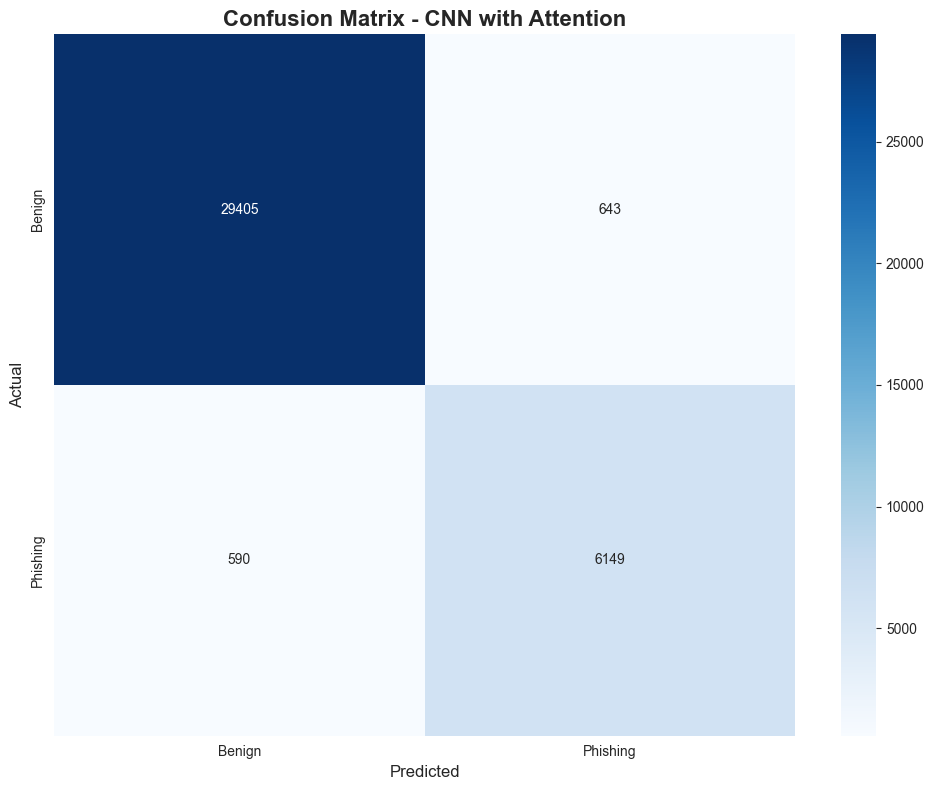

In [25]:
# ============================================
# CONFUSION MATRIX
# ============================================

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred_optimized)

print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

fpr = cm[0,1] / (cm[0,0] + cm[0,1])
fnr = cm[1,0] / (cm[1,0] + cm[1,1])

print(f"\nFalse Positive Rate: {fpr*100:.2f}%")
print(f"False Negative Rate: {fnr*100:.2f}%")

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.title('Confusion Matrix - CNN with Attention', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()


ROC CURVE
ROC AUC: 0.9892


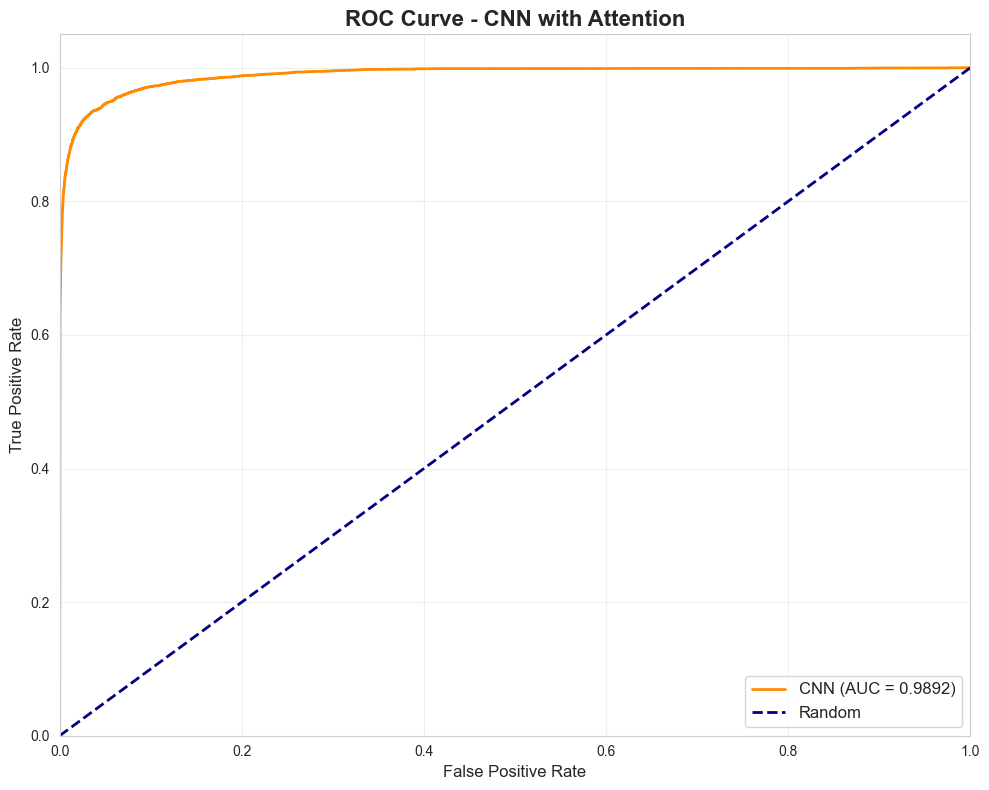

In [26]:
# ============================================
# ROC CURVE
# ============================================

print("\n" + "="*60)
print("ROC CURVE")
print("="*60)

roc_auc = roc_auc_score(y_test, y_probs)
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_probs)

print(f"ROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2,
         label=f'CNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - CNN with Attention', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


TRAINING CURVES


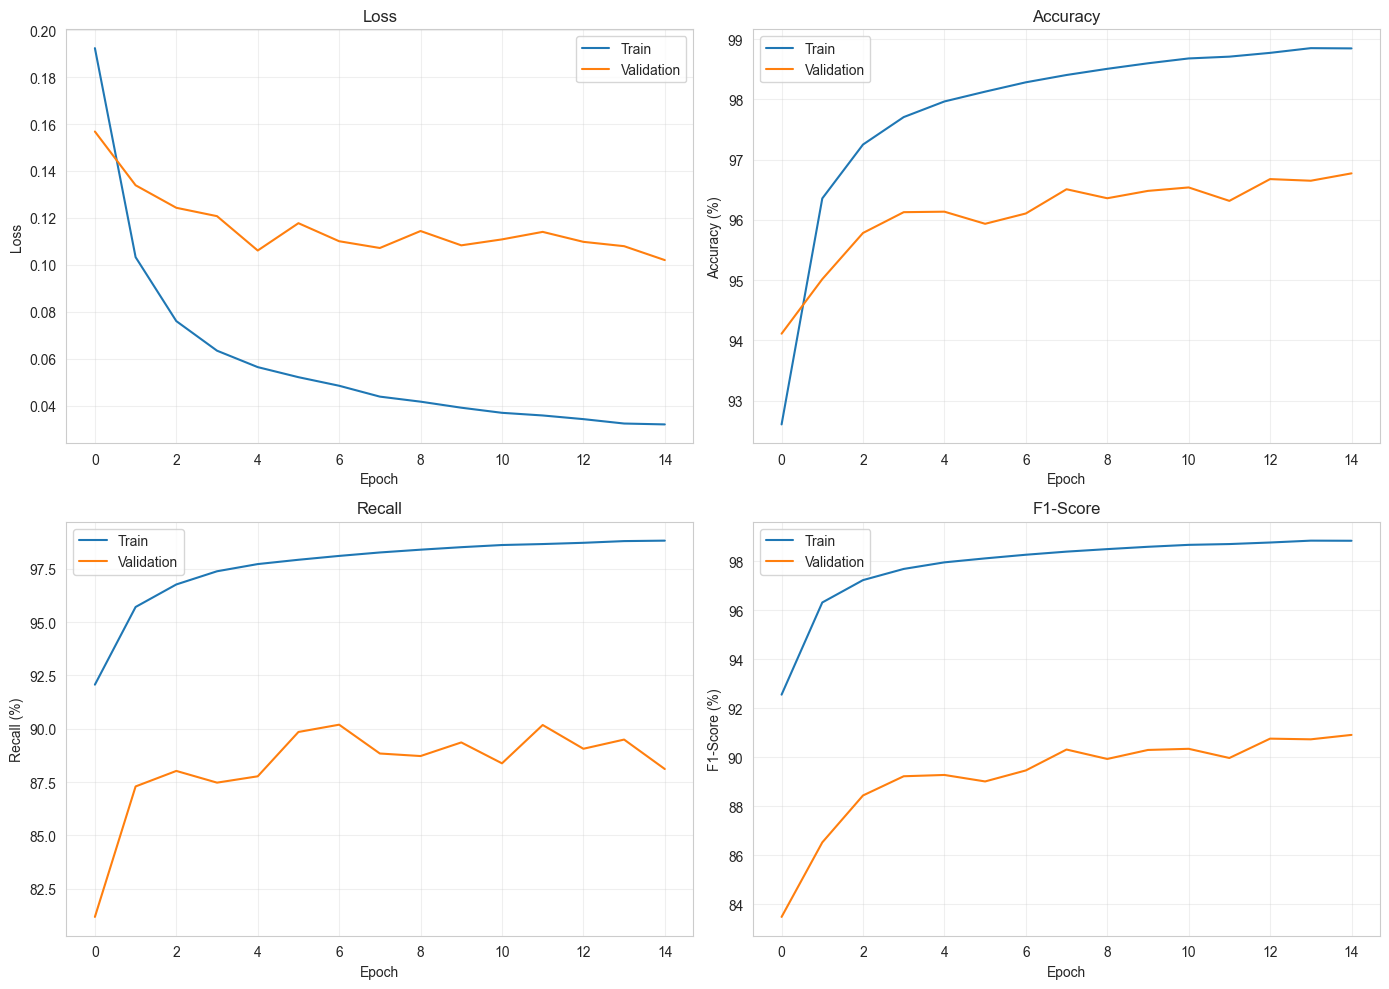

In [27]:
# ============================================
# TRAINING CURVES
# ============================================

print("\n" + "="*60)
print("TRAINING CURVES")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Validation')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot([x*100 for x in history['train_acc']], label='Train')
axes[0, 1].plot([x*100 for x in history['val_acc']], label='Validation')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Recall
axes[1, 0].plot([x*100 for x in history['train_recall']], label='Train')
axes[1, 0].plot([x*100 for x in history['val_recall']], label='Validation')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall (%)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# F1-Score
axes[1, 1].plot([x*100 for x in history['train_f1']], label='Train')
axes[1, 1].plot([x*100 for x in history['val_f1']], label='Validation')
axes[1, 1].set_title('F1-Score')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1-Score (%)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Save tokenizer
tokenizer_path = '../../../models/url-detection/char_tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump({'char_to_idx': char_to_idx, 'max_length': MAX_URL_LENGTH}, f)
print(f"Tokenizer saved: {tokenizer_path}")

# # Save metrics
# metrics = {
#     'model': 'CNN with Attention',
#     'test_accuracy': float(test_acc),
#     'test_precision': float(test_prec),
#     'test_recall': float(test_recall),
#     'test_f1': float(test_f1),
#     'roc_auc': float(roc_auc),
#     'total_params': total_params,
#     'trained_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# }

# metrics_df = pd.DataFrame([metrics])
# metrics_path = '../../../models/url-detection/cnn_metrics.csv'
# metrics_df.to_csv(metrics_path, index=False)
# print(f"Metrics saved: {metrics_path}")

Tokenizer saved: ../../../models/url-detection/char_tokenizer.pkl


In [29]:
# ========================================
# Convert to TorchScript for deployment 
# ========================================

print("CONVERTING MODEL TO TORCHSCRIPT")

# Load best model
print("\nLoading best model...")
model.load_state_dict(torch.load('../../../models/url-detection/cnn_best.pth'))
model.eval()

# Create dummy input
print("Creating dummy input...")
dummy_input = torch.randint(0, vocab_size, (1, MAX_URL_LENGTH)).to(device)

# Trace the model
print("Tracing model...")
traced_model = torch.jit.trace(model, dummy_input)

# Save traced model
torchscript_path = '../../../models/url-detection/cnn_torchscript.pt'
torch.jit.save(traced_model, torchscript_path)

file_size = os.path.getsize(torchscript_path) / 1e6

print(f"\nTorchScript model saved: {torchscript_path}")
print(f"File size: {file_size:.2f} MB")

CONVERTING MODEL TO TORCHSCRIPT

Loading best model...
Creating dummy input...
Tracing model...

TorchScript model saved: ../../../models/url-detection/cnn_torchscript.pt
File size: 7.50 MB


In [8]:
# ========================================
# TEST MODEL WITH REAL-WORLD URLs
# ========================================

print("="*60)
print("TESTING WITH REAL-WORLD URLs")
print("="*60)

# Test URLs (mix of benign and phishing)
test_urls_list = [
    # Major benign websites
    ("https://www.google.com", "benign"),
    ("https://github.com", "benign"),
    ("https://www.microsoft.com", "benign"),
    ("https://www.amazon.com", "benign"),
    ("https://www.wikipedia.org", "benign"),
    ("https://www.stackoverflow.com", "benign"),
    ("https://www.reddit.com", "benign"),
    ("https://www.youtube.com", "benign"),
    ("https://www.twitter.com", "benign"),
    ("https://www.linkedin.com", "benign"),
    
    # Suspicious/Phishing-like URLs
    ("http://secure-paypal-verify.tk/login", "phishing"),
    ("https://www.paypal-secure-login.com/verify", "phishing"),
    ("http://amazon-account-verify.xyz", "phishing"),
    ("https://microsoft-account-recovery.tk/login", "phishing"),
    ("http://appleid-unlock.ml/verify", "phishing"),
    ("https://secure-login-facebook.com/account", "phishing"),
    ("http://instagram-verify-account.tk", "phishing"),
    ("https://netflix-billing-update.ml/payment", "phishing"),
    ("http://google-account-security.tk/verify", "phishing"),
    ("https://amazon-prize-winner.com/claim", "phishing"),
]

torchscript_path = '../../../models/url-detection/cnn_torchscript.pt'

OPTIMAL_THRESHOLD=0.30

# Load model
print("\nLoading TorchScript model...")
model_loaded = torch.jit.load(torchscript_path, map_location=device)
model_loaded.eval()

print("\nTesting URLs...")
print(f"\n{'URL':<60} {'Expected':<12} {'Score':<8} {'Prob':<8} {'Result'}")
print("="*100)

results = []
for url, expected in test_urls_list:
    # Tokenize URL
    url_tokens = tokenize_url(url, char_to_idx, MAX_URL_LENGTH)
    url_tensor = torch.LongTensor([url_tokens]).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model_loaded(url_tensor)
        if isinstance(output, tuple):
            logits = output[0]
        else:
            logits = output
        
        probability = torch.sigmoid(logits).item()
    
    # Convert to score (0-10)
    score = round(probability * 10, 2)
    
    # Determine result based on optimal threshold
    predicted = "phishing" if probability >= OPTIMAL_THRESHOLD else "benign"
    is_correct = "✓" if predicted == expected else "✗"
    
    results.append({
        'url': url,
        'expected': expected,
        'probability': probability,
        'score': score,
        'predicted': predicted,
        'correct': is_correct
    })
    
    # Truncate URL for display
    display_url = url[:57] + "..." if len(url) > 60 else url
    print(f"{display_url:<60} {expected:<12} {score:<8.2f} {probability:<8.4f} {is_correct}")

# Calculate accuracy
correct = sum(1 for r in results if r['correct'] == '✓')
total = len(results)
accuracy = correct / total * 100

print("="*100)
print(f"\nAccuracy: {correct}/{total} = {accuracy:.1f}%")

# Show misclassifications
print("\n" + "="*60)
print("MISCLASSIFICATIONS")
print("="*60)

for r in results:
    if r['correct'] == '✗':
        print(f"\nURL: {r['url']}")
        print(f"Expected: {r['expected']}, Predicted: {r['predicted']}")
        print(f"Probability: {r['probability']:.4f}, Score: {r['score']}")

TESTING WITH REAL-WORLD URLs

Loading TorchScript model...

Testing URLs...

URL                                                          Expected     Score    Prob     Result
https://www.google.com                                       benign       6.50     0.6502   ✗
https://github.com                                           benign       0.04     0.0041   ✓
https://www.microsoft.com                                    benign       2.82     0.2823   ✓
https://www.amazon.com                                       benign       0.05     0.0051   ✓
https://www.wikipedia.org                                    benign       0.00     0.0001   ✓
https://www.stackoverflow.com                                benign       0.61     0.0608   ✓
https://www.reddit.com                                       benign       0.35     0.0354   ✓
https://www.youtube.com                                      benign       0.67     0.0669   ✓
https://www.twitter.com                                      benign     